# Markov Decision Processes

## 1. Markov Process (MP)
A $Markov \ Process$ (or $Markov \ Chain$) is a memoryless randam process. It's a sequence of random stantes $S_1, S_2,...$ with the Markov property.
So there are 2 components of MP:
* A finite set of states which satisfy Markov property.
* A corresponding state transition probability matrix.

### 1.1 Markov Property
A state $S_t$ is $Markov$ if and and only if:
$$P(S_{t+1} \mid S_t)=P(S_{t+1} \mid S_1,...,S_t)$$

### 1.2 State Transition Matrix
For a Markov state $s$ and successor state $s^{'}$, the $state \ transition \ probability$ is defined by:
$$\mathcal P_{ss^{'}}=P(S_{t+1}=s^{'} \mid S_t=s)$$
State transition matrix $P$ defines transition probabilities from all state $s$ to all successor states $s^{'}$.
* We define the row represent the current state, then the sum of each row of the matrix is 1.

### 1.3 Class Design of MP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Mapping
from utils.generic_typevars import S
from utils.utils import is_equal

class MP:
    def __init__(self, transitions: Mapping[S, Mapping[S, float]]):
        if self.check_mp(transitions):
            self.transitions = transitions
            self.states = list(self.transitions.keys())
            self.transition_matrix = self.generate_matrix(self.transitions)
        else:
            raise ValueError
    
    def check_mp(self, transitions) -> bool:
        states = set(transitions.keys())
        # Check the successor states is the subset of current states
        b1 = set().union(*list(transitions.values())).issubset(states)
        # Check the probabilities are positive
        b2 = all(all(p >= 0 for p in transitions[state].values()) for state in transitions)
        # Check the sum of probabilities for each state equals to 1
        b3 = all(is_equal(sum(transitions[state].values()), 1.) for state in transitions)        
        return b1 and b2 and b3
    
    def generate_matrix(self, dict_obj) -> np.array:
        matrix = np.zeros((len(self.states), len(self.states)))
        
        for i in range(len(self.states)):
            for j in range(len(self.states)):
                if self.states[j] in dict_obj[self.states[i]]:
                    matrix[i, j] = dict_obj[self.states[i]][self.states[j]]
        return matrix
    
    def simulation(self, iters: int) -> None:
        p0 = np.random.rand(len(self.states))
        p0 /= sum(p0)
        simulation = np.zeros((iters, len(self.states)))
        
        for i in range(iters):
            p0 = p0.dot(self.transition_matrix)
            simulation[i, :] = p0
        
        for i in range(len(self.states)):
            plt.plot(range(iters), simulation[:, i])

In [2]:
transitions = {
    1: {1: 0.2, 2: 0.3, 3: 0.1, 4: 0.1, 5: 0.3},
    2: {1: 0.15, 2: 0.35, 3: 0.25, 5: 0.25},
    3: {1: 0.55, 2: 0.12, 4: 0.33},
    4: {1: 0.2, 2: 0.5, 3: 0.2, 5: 0.1},
    5: {5: 1}
}
    
mp = MP(transitions)
print('States:', mp.states, '\n')
print('Transition Matrix:\n', mp.transition_matrix)

States: [1, 2, 3, 4, 5] 

Transition Matrix:
 [[0.2  0.3  0.1  0.1  0.3 ]
 [0.15 0.35 0.25 0.   0.25]
 [0.55 0.12 0.   0.33 0.  ]
 [0.2  0.5  0.2  0.   0.1 ]
 [0.   0.   0.   0.   1.  ]]


### 1.4 Stationary Distribution
Then I want to explore the stationary distribution of this markov process by simulation. Generate some initial distribution probabilities p0, and do simulations for several iterations. The result shows that the probabilities always converge. Thus, this markov process has stationary distribution.

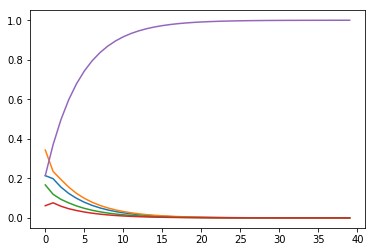

In [3]:
mp.simulation(40)

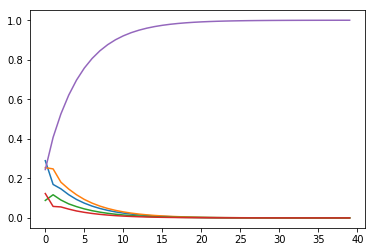

In [4]:
mp.simulation(40)

## 2. Markov Reward Process (MRP)
A $Markov \ Reward \ Process$ is a Markov chain with values. Remember that Markov chain has 2 components, now a MRP has 4 components:
* A finite set of states which satisfy Markov property.
* A corresponding state transition probability matrix.
* A reward function.
* A discount factor.

### 2.1 Reward and Reward Function
The $reward \ R_t$ is a feedback from the enviroment when the state transits from $S_{t-1}$ to $S_t$. Then what is the $reward \ function$? Here I list 2 definitions of reward function:
* In Wikipedia, the reward function consider all situations between the current state $s$ and successor state $s^{'}$. So this reward function has the same shape as the state transition matrix:
$$\mathcal R_{ss^{'}}=R(S_t=s,S_{t+1}=s^{'})$$
* In David Silver's lecture, the reward function is defined as the conditional expectation of the random variable $R_{t+1}$ at state $S_t=s$:
$$\mathcal R_{s}=E[R_{t+1} \mid S_t=s]$$

Consider the data structure of these 2 types of definition. The reward function of Wiki MRP is a matrix of size $n\_state*n\_state$. The reward function of DS MRP is a vector of size $n\_state$, and can be converted by calculate the dot product of each row in state transition matrix and the corresponding row in reward matrix from Wiki MRP:
$$\mathcal R_{s}=\sum_{s^{'}}\mathcal P_{ss^{'}}\times \mathcal R_{ss^{'}}$$


### 2.2 Return and Discount Factor
The $return \ G_t$ is the total discounted reward from time-step $t$:
$$G_t=R_{t+1}+\gamma R_{t+2}+...=\sum_{k=0}^{\infty}\gamma^k R_{t+k+1}$$
* The discount factor $\gamma \in [0,1]$ is the present value of future rewards in one step.

### 2.3 Class Design of MRP
Consider the Wiki's definition of MRP, generate a reward matrix which has the same rows and columns as state transition matrix. Then convert it to the DS's definition of MRP.

In [5]:
class MRP(MP):
    def __init__(self, transitions: Mapping[S, Mapping[S, float]], \
                 rewards: Mapping[S, Mapping[S, float]], gamma: float):
        if self.check_mp(transitions):
            self.transitions = transitions
            self.states = list(self.transitions.keys())
            self.rewards = rewards
            self.transition_matrix = self.generate_matrix(self.transitions)
            self.reward_func = self.generate_matrix(self.rewards)
        else:
            raise ValueError
    
    def convert_reward_func(self):
        reward_func_new = np.zeros(len(self.states))
        
        for i in range(len(self.states)):
            reward_func_new[i] = np.dot(self.transition_matrix[i, :], self.reward_func[i, :])
        return reward_func_new

In [6]:
rewards = {
    1: {1: 3, 2: 8, 3: 10, 4: 5, 5: 3},
    2: {1: 2, 2: 7, 3: 9, 5: 2},
    3: {1: 0, 2: 1, 4: 3},
    4: {1: 0, 2: 4, 3: 5, 5: 2},
    5: {5: 1}
}
mrp = MRP(transitions, rewards, 1.)
print('Reward Function (Wiki):\n', mrp.reward_func, '\n')
print('Reward Function (DS):\n', mrp.convert_reward_func(), '\n')

Reward Function (Wiki):
 [[ 3.  8. 10.  5.  3.]
 [ 2.  7.  9.  0.  2.]
 [ 0.  1.  0.  3.  0.]
 [ 0.  4.  5.  0.  2.]
 [ 0.  0.  0.  0.  1.]] 

Reward Function (DS):
 [5.4  5.5  1.11 3.2  1.  ] 

